In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-drone-dataset/class_dict_seg.csv
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/173.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/491.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/043.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/248.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/038.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/480.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/236.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/083.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/513.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_da

# Introduction of Semantic Segmentation

the goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented.  
Because we're predicting for every pixel in the image, this task is commonly referred to as dense prediction.

<img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-7.42.16-PM.png" width="700px"  />

### Field of Application

|**Autonomous Driving**|**Medical Image Diagnostics**|
|---|---|
|<img src="https://storage.googleapis.com/kaggle-media/competitions/cvpr/image_example.jpg" width="300px"  />|<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs12880-020-00543-7/MediaObjects/12880_2020_543_Fig3_HTML.jpg" width="300px"  />|


## Typical network for Semantic Segmentation
- FCN, SegNet, UNet, DeepLab, ENet etc

> ### FCN   
 
 Adopted Skip Connection to provide the necessary detail in order to reconstruct accurate shapes for segmentation boundaries.  
 Deconvolution's procedures are so simple that the details of the object disappear.  
 <img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-20-at-12.26.53-PM.png" width="700px"/>
 
> ### UNet   
 
 UNet consists of a U-shaped network.  
 UNet proposed a model that applied Up-sampling and Skip Archetecture of an expanded concep than FCNs.
 <img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-20-at-1.46.43-PM.png" width="700px"/>
 
## MobileUNet
Using MobileNet as a backbone of UNet to speed up applications.  
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlS9vx%2Fbtq3DGy86Av%2FvLwlUcjx4JTSq0Xz6jQ0Sk%2Fimg.png" width="1000px"/>

In [42]:
## Import libraries 

import cv2
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
# from keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from keras.utils import plot_model
import os

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9877066202742328100
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15683598464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12093592806378746789
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
## Data Augmentation
## It was chosen the resolution of 1536x1024px keep the ratio of the original images (6000x4000px). 

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def augment_data(images, masks, save_path, augment=True):
    H = 1024
    W = 1536
    for x,y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]       
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        y = cv2.imread(y, cv2.IMREAD_COLOR)
        y = cv2.resize(y, (W, H))
        
        if augment == True:
            
            aug = RandomCrop(int(2*H/3), int(2*W/3), always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]
 
            aug = HorizontalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]
            
            aug = VerticalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"] 
            
            save_images = [x, x1, x2, x3]
            save_masks = [y, y1, y2, y3]            
          
        else:
            save_images = [x]
            save_masks = [y]
        
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            
            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}" 
            
            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_msk_name)
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx+=1


path = "../input/semantic-drone-dataset/dataset/semantic_drone_dataset/"
images = sorted(glob(os.path.join(path, "original_images/*")))
masks = sorted(glob(os.path.join(path, "label_images_semantic/*")))
print(f"Original images:  {len(images)} - Original masks: {len(masks)}")

create_dir("./new_data/images/")
create_dir("./new_data/masks/")

save_path = "./new_data/"

augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

  0%|          | 0/400 [00:00<?, ?it/s]

Original images:  400 - Original masks: 400


100%|██████████| 400/400 [05:55<00:00,  1.12it/s]

Augmented images:  1600 - Augmented masks: 1600


In [5]:
## Create dataframe

image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

Total Images:  1600


In [6]:
## Split data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19)
X_trainval=df_images['id']
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Train Size : 1280 images
Val Size   :  320 images
Test Size  :  160 images


In [31]:
from keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate, Conv2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.optimizers import Adam

def mobileunet(input_size, num_classes):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)    
    
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)
    
    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)
    
    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)
    
    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)    
    conv8  = BatchNormalization()(conv8)
    
    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)        
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    output = conv10
    return Model(inputs, output)

In [32]:
## Define the resolution of the images and the number of classes


H = 768   #to keep the original ratio 
W = 1152 
num_classes = 23

#model = build_unet((W, H, 3), num_classes)  
model = mobileunet((W, H, 3),num_classes)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 768, 1152, 3 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 768, 1152, 32 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 768, 1152, 32 128         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_87 (Activation)      (None, 768, 1152, 32 0           batch_normalization_134[0][0]    
___________________________________________________________________________________________

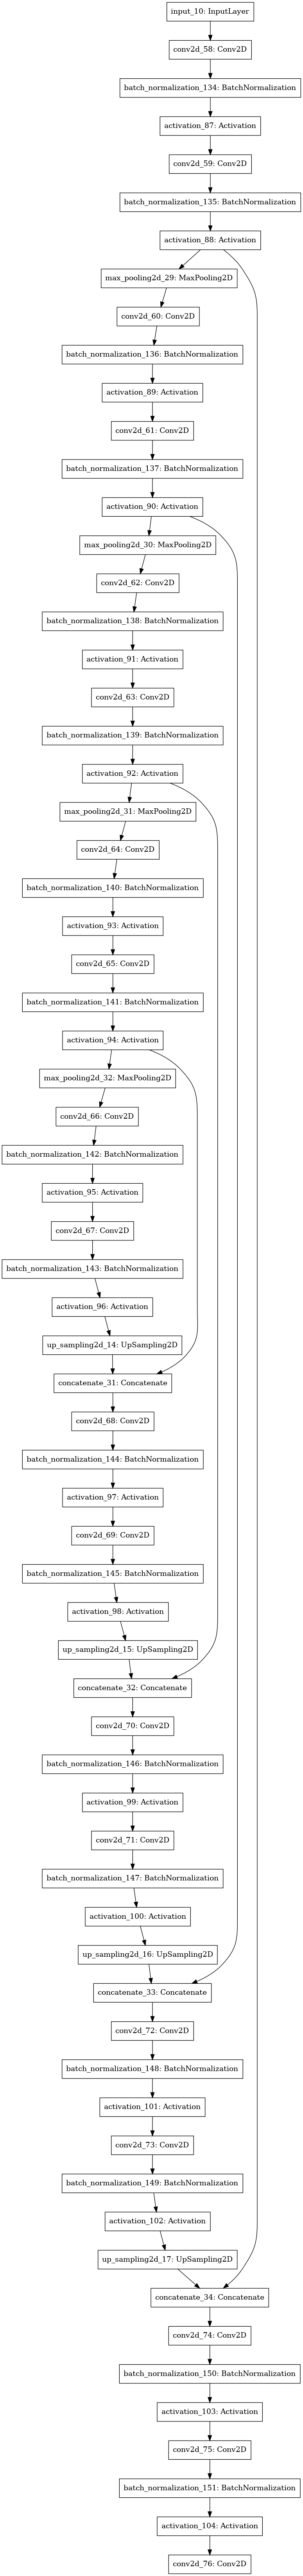

In [43]:
model.summary()
plot_model(model,to_file='model.png')

In [34]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

In [35]:
## Train the model

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
shape = (H, W, 3)
num_classes = 23  
lr = 1e-4
batch_size = 4
epochs = 20

# Model
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

checkpointer = [
    ModelCheckpoint(filepath="./model.h5",monitor='val_loss',verbose=2,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=checkpointer
         )

Epoch 1/20
320/320 [==============================] - 256s 793ms/step - loss: 2.4547 - accuracy: 0.4347 - val_loss: 2.2654 - val_accuracy: 0.4262

Epoch 00001: val_loss improved from inf to 2.26539, saving model to ./model.h5
Epoch 2/20
320/320 [==============================] - 252s 787ms/step - loss: 1.7590 - accuracy: 0.6267 - val_loss: 1.5124 - val_accuracy: 0.6653

Epoch 00002: val_loss improved from 2.26539 to 1.51240, saving model to ./model.h5
Epoch 3/20
320/320 [==============================] - 252s 786ms/step - loss: 1.4543 - accuracy: 0.6717 - val_loss: 1.2016 - val_accuracy: 0.7181

Epoch 00003: val_loss improved from 1.51240 to 1.20163, saving model to ./model.h5
Epoch 4/20
320/320 [==============================] - 252s 787ms/step - loss: 1.2791 - accuracy: 0.6891 - val_loss: 1.1000 - val_accuracy: 0.7209

Epoch 00004: val_loss improved from 1.20163 to 1.09996, saving model to ./model.h5
Epoch 5/20
320/320 [==============================] - 252s 788ms/step - loss: 1.1505

In [36]:
## Prediction

create_dir('./results')  #create the folder for the predictions

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Model
model = tf.keras.models.load_model("model.h5")

# Saving the masks
for x, y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    
    ## Read image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)

    ## Read mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    
    y = np.expand_dims(y, axis=-1) #(384,256,1)
    
    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)
    
    ## Prediction
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    
    p = np.expand_dims(p, axis=-1)  
    
    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)
      
    cv2.imwrite(f"./results/{name}", p)
    

100%|██████████| 160/160 [00:44<00:00,  3.63it/s]


In [37]:
# From the test set, take only images that represent the ones in the original dataset and not those are obtained from the data augmentation.
# (they have _0 in the name)

image_list = []
mask_list = []

for x,y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    image_name = name[4]

    name = y.split("/")[-1]
    mask_name = name[4]
    
    if image_name == '0':
        image_list.append(x)
        mask_list.append(y)

100%|██████████| 160/160 [00:00<00:00, 207446.26it/s]


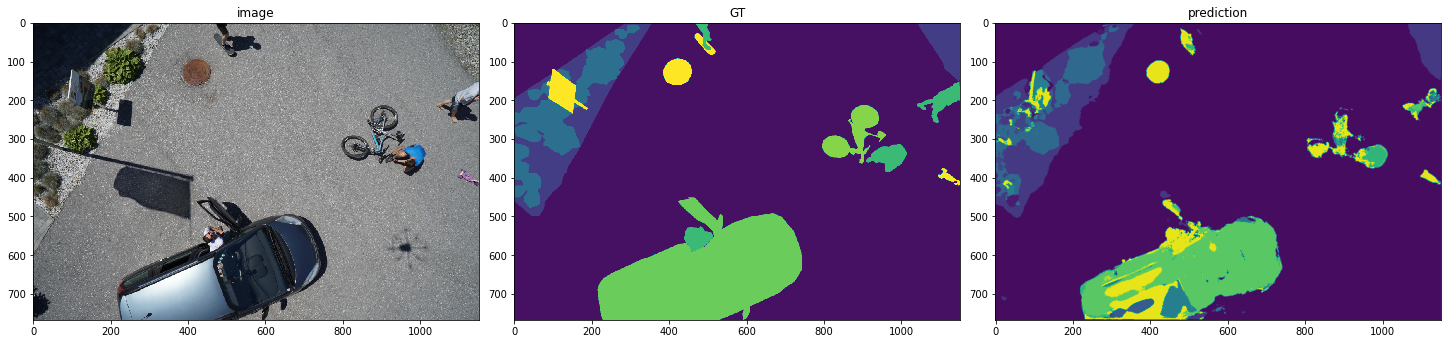

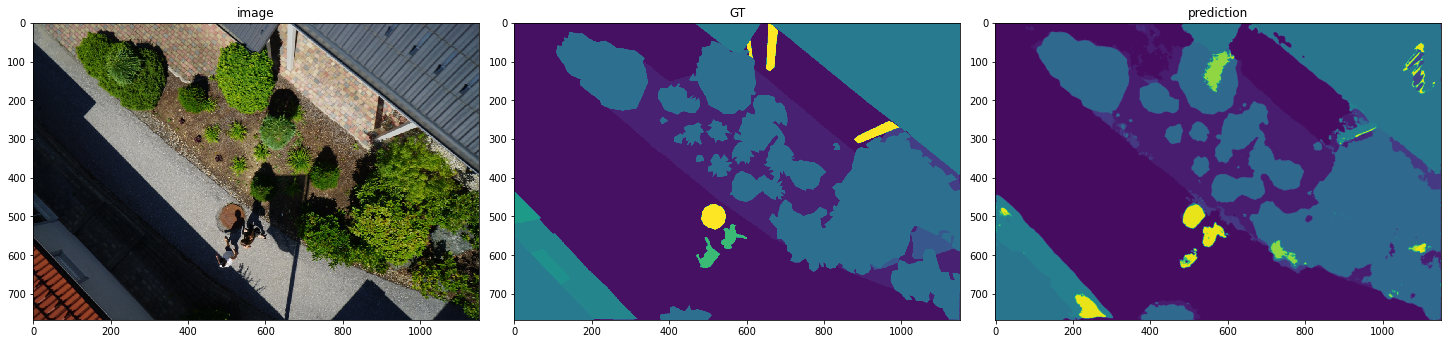

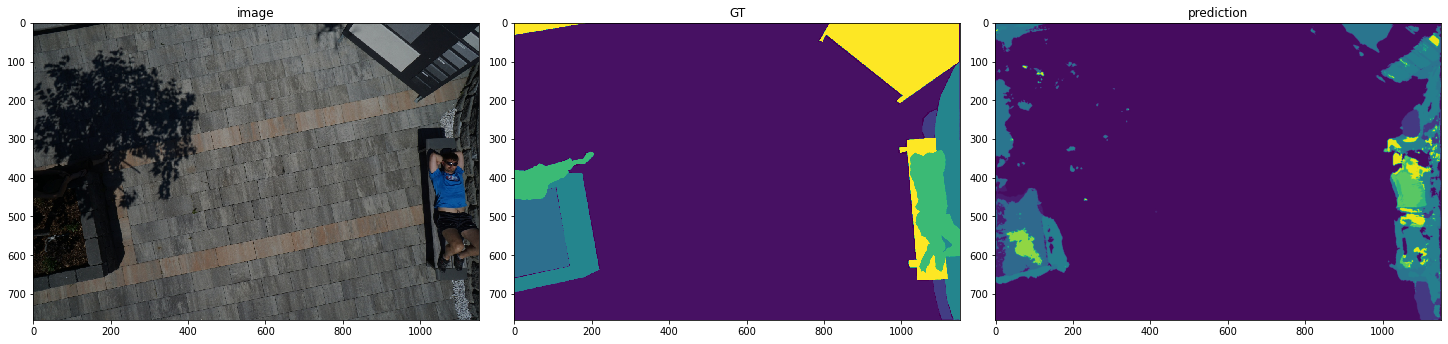

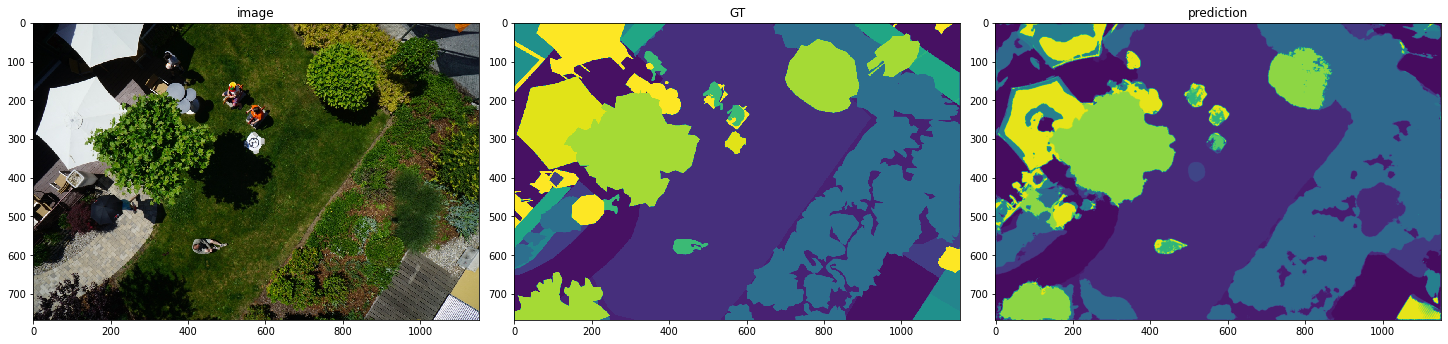

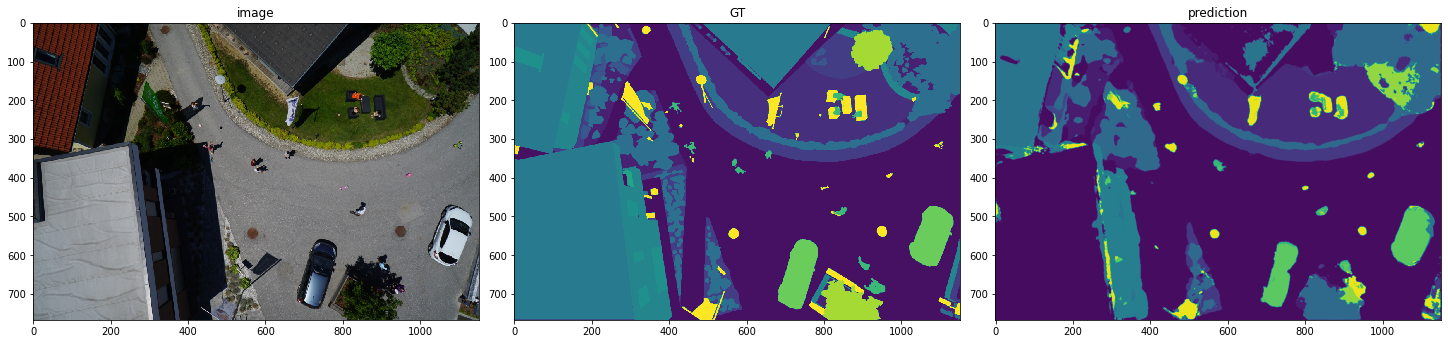

In [40]:
## Plot 5 images to verify the accuracy in the predictions

img_selection = image_list[10:15]
mask_selection = mask_list[10:15]

for img, mask in zip(img_selection, mask_selection):
    name = img.split("/")[-1]
    x = cv2.imread(img, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (W, H))

    y = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))


    p = cv2.imread(f"./results/{name}", cv2.IMREAD_GRAYSCALE)
    p = cv2.resize(p, (W, H))

    #Plotto le tre immagini
    fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

    axs[0].imshow(x, interpolation = 'nearest')
    axs[0].set_title('image')
    axs[0].grid(False)

    axs[1].imshow(y, interpolation = 'nearest')
    axs[1].set_title('GT')
    axs[1].grid(False)

    axs[2].imshow(p)
    axs[2].set_title('prediction')
    axs[2].grid(False)